<a href="https://colab.research.google.com/github/sachalapins/U-GPD/blob/main/2_UGPD_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running U-GPD Transfer Learning Model on Data from Nabro Volcano

Last updated 13th Mar 2023.

---

The code in this notebook accompanies the JGR: Solid Earth paper **_"Lapins et al. (2021) A Little Data goes a Long Way: Automating Seismic Phase Arrival Picking at Nabro Volcano with Transfer Learning"_**, https://doi.org/10.1029/2021JB021910 (open access).

The resulting catalogue of seismicity, including event locations and model picks, has been archived at https://doi.org/10.5281/zenodo.7398824. The training, validation and test datasets can be found at https://doi.org/10.5281/zenodo.4498549.

If you find the code, data or results in this notebook useful, please consider citing the above paper or datasets.

This notebook was originally developed and tested in Google Colab in 2021 using TensorFlow version 1. Colab no longer supports TensorFlow version 1 so it has now been updated to run in TensorFlow 2.

If you have any suggestions for improvements, issues running the code or notice any errors then please feel free to contact me ([sacha.lapins@bristol.ac.uk](mailto:sacha.lapins@bristol.ac.uk)).

Many thanks.

Sacha Lapins, University of Bristol
<br>



---

In this notebook, we demonstrate how to run our U-GPD transfer learning model, trained after incorporating pre-trained weights from the extensively-trained GPD model (Ross et al., 2018, BSSA, https://doi.org/10.1785/0120180080) within a U-Net architecture. Please see the first accompanying notebook to this paper, [1_UGPD_training.ipynb: Training U-GPD Transfer Learning Model for Nabro Volcano](https://github.com/sachalapins/U-GPD/blob/main/1_UGPD_training.ipynb), for details on how to produce and train this model [*NB notebook needs updating for TF version 2*]

<br>

## 1. Install obspy

First, make sure Hardware Accelerator is set to GPU (click on 'Runtime' menu at top, then 'Change runtime type', then make sure GPU is selected from drop down menu under 'Hardware accelerator').

Then install `obspy` using `pip`.

(**IMPORTANT:** You must restart runtime after this step and then run notebook again from the beginning, otherwise obspy will not read or download data correctly. Click on 'Runtime' menu at top, then 'Restart runtime')

In [1]:
!pip install obspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2. Load modules etc

Then, let's load required modules and define some functions.

In [2]:
# Import modules
import string
import time
import argparse as ap
import sys
import os
import glob

import numpy as np
import pandas as pd
import obspy.core as oc
from obspy.signal.trigger import trigger_onset
from obspy.core.utcdatetime import UTCDateTime

import matplotlib.pyplot as plt

import math # for pi, sqrt, etc

import tensorflow as tf # version 2
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import losses

import h5py
import json

import random

import scipy.stats as stats
import scipy.signal as signal

from datetime import datetime

In [3]:
# Define function to produce sliding windows of signal (from original GPD GitHub repo https://github.com/interseismic/generalized-phase-detection/blob/master/gpd_predict.py)

def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided

## 3. Download and load trained U-GPD Transfer Learning model

Next let's clone the repo for our trained U-GPD Transfer Learning model and load our trained model with weights from the training epoch that gave lowest validation loss.

In [4]:
!git clone https://github.com/sachalapins/U-GPD.git

Cloning into 'U-GPD'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 170 (delta 14), reused 0 (delta 0), pack-reused 140
Receiving objects: 100% (170/170), 12.46 MiB | 23.45 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [5]:
# Load model and weights
model = load_model('./U-GPD/model/best/ugpd_tf2', compile=False)
print("*** U-GPD MODEL AND WEIGHTS LOADED FROM DISK ***")

*** U-GPD MODEL AND WEIGHTS LOADED FROM DISK ***


## 4. Download 24 hours data from Nabro

GitHub doesn't allow uploading of large files so we need to download our Nabro data from the [IRIS dataselect Web Service](http://service.iris.edu/fdsnws/dataselect/1/) before we can run our model.

Let's choose a day that wasn't included in any of the training, validation or test data (2011-09-26).

**Note: This step can take a long time (over half an hour) so I have [archived the data on Zenodo](https://doi.org/10.5281/zenodo.7646981). If you wish to download the data using the IRIS dataselect service, simply uncomment the code block below (but be prepared to wait) and don't run the following code block. You can also download it through the obspy client but this appears to take even longer.**

In [6]:
# #### UNCOMMENT THIS CELL TO DOWNLOAD NABRO DATA FROM IRIS ####

# # Give start and end time to extract data
# station = "NAB*"
# day = "2011-09-26"
# starttime = UTCDateTime(day + "T00:00:00")
# endtime = UTCDateTime(day + "T23:59:59.999999")

# # Get waveforms for network 4H on this day and save as mseed (seems to be a little quicker than using the obspy client to request data)
# before = datetime.now()
# os.system("wget -O nabro_2011-247.mseed http://service.iris.edu/fdsnws/dataselect/1/query?net=4H\&sta=" + station + "\&loc=*\&cha=HH?\&start=" + str(starttime)[0:-1] + "\&end=" + str(endtime)[0:-1])
# after = datetime.now()
# print(after-before)

In [7]:
#### ALTERNATIVELY, THIS CELL DOWNLOADS DATA DIRECTLY FROM ACHIVED ZENODO REPOSITORY ####

# This file file is approx 380 MB so takes a few minutes to download...
before = datetime.now()
os.system("wget -O nabro_2011-269.mseed https://zenodo.org/record/7646981/files/nabro_2011-269.mseed?download=1 --show-progress")
after = datetime.now()
print(after-before)

0:11:38.353934


In [8]:
#### UNCOMMENT THIS CELL IF DOWNLOADED NABRO DATA USING ABOVE ####
import glob
files = glob.glob("./nabro_2011-269.mseed") # List files

In [9]:
# Load waveforms into obspy
st = oc.Stream()
for f in np.arange(0, len(files)):
    st += oc.read(files[f])
st.sort()
            
stations = list(set([st[s].stats.station for s in np.arange(0, len(st))]))

In [10]:
print(st)

513 Trace(s) in Stream:

4H.NAB1..HHE | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
...
(511 other traces)
...
4H.NAB8..HHZ | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


The obspy Stream has 513 traces, even though there are only 7 operational stations on this day. This is because station NAB7 drops in and out every few minutes.

As such, to avoid lots of spurious triggers caused by these data gaps, let's remove NAB7 from this Stream.

In [11]:
for s in st:
    if s.stats.station == "NAB7":
        st.remove(s)

print(st)

18 Trace(s) in Stream:
4H.NAB1..HHE | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB1..HHN | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB1..HHZ | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB2..HHE | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB2..HHN | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB2..HHZ | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB3..HHE | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB3..HHN | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB3..HHZ | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB4..HHE | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990

## 5. Define some parameters for sliding window and phase arrival trigger

In [12]:
# Model prediction parameters
shift_size = 200 # Overlap (in samples) for sliding window
batch_size = 100 # No. of windows to process at a time

# Trigger parameters
p_thresh = 0.4 # Trigger on threshold for P-waves
s_thresh = 0.4 # Trigger on threshold for S-waves
trig_off = 0.2 # Trigerr off threshold for both phase arrivals

## 6. Run model using sliding window on continuous data

In this step, we loop through each available station, dividing the data from each instrument channel into overlapping 400-sample windows (with 200-sample overlap) and then run our model on these windows.

We keep only the middle 200 samples from each window to avoid poor predictions at the window edges.

We then apply a simple trigger algorithm in obspy to a concatenated array of all these window predictions (one long prediction trace with same sample rate as the input data). Any P- or S-wave predictions that exceed the trigger thresholds given above (`p_thresh` and `s_thresh`) will be added to the dataframe `df` of phase arrival pick times, along with their 'probabilities' (a measure of model confidence in that phase arrival classification).

In [13]:
# List available stations
stations = list(set([st[s].stats.station for s in np.arange(0, len(st))]))

# Dataframe to store picks from trigger
df = pd.DataFrame(columns=['time', 'sta', 'pha', 'prob'])

# Empty obspy stream to store prediction traces
st_pred = oc.Stream()

# Loop through list of available stations
before = datetime.now() # Get time before and after to see how long this takes
for s in np.arange(0, len(stations)):

    st2 = st.copy().select(station=stations[s])
    
    # If there are data gaps (i.e., more than 3 traces per station) then merge the traces together
    no_of_traces_per_station = st2.count() / 3
    
    if no_of_traces_per_station > 1:
        st2.merge(method=0, fill_value=0)
    
    # Trim to same length:
    latest_start = np.max([x.stats.starttime for x in st2])
    earliest_stop = np.min([x.stats.endtime for x in st2])
    st2.trim(latest_start, earliest_stop)        
    
    # Expand overlapping windows using sliding_window function
    sliding_E = sliding_window(st2[0].data, 400, stepsize=shift_size) # Slide window across first component
    tr_win = np.zeros((sliding_E.shape[0], 400, 3)) # 3D array (of zeros)
    tr_win[:,:,0] = sliding_E # Add to 3D array
    sliding_E = None # clear some memory
    
    sliding_N = sliding_window(st2[1].data, 400, stepsize=shift_size) # Slide window across second component
    tr_win[:,:,1] = sliding_N # Add to 3D array
    sliding_N = None # clear some memory
    
    sliding_Z = sliding_window(st2[2].data, 400, stepsize=shift_size) # Slide window across third component
    tr_win[:,:,2] = sliding_Z # Add to 3D array
    sliding_Z = None # clear some memory
    
    tr_win = signal.detrend(tr_win, axis=1) # Detrend 
    tr_win = tr_win / np.max(np.abs(tr_win), axis=(1,2))[:,None,None] # Normalize between 0 and 1 (divide by max across 3 components for each window)
    
    # Model prediction step...
    ts = model.predict(tr_win, verbose=True, batch_size=batch_size)
    
    # Merge overlapping predictions:
    n_steps_per_win = 400/shift_size # No. of steps per window (i.e. how many overlapping windows)
    class_trace = np.zeros((len(st2[0].data), int(3))) # Create prediction traces to be same size as input data
    for i in np.arange(0, ts.shape[0]): # For each window
        class_trace[((i * shift_size) + 100):((i * shift_size) + 300), :] += ts[i, 100:300, :] # Keep middle 200 predictions
    
    # Create obspy stream for P-pick prediction trace
    p_trace = oc.Trace()
    p_stream = oc.Stream()
    p_stream += p_trace
    p_stream[0].data = class_trace[:,0]
    p_stream[0].stats = st2.copy()[0].stats
    p_stream[0].stats.channel = "P"

    # Create obspy stream for S-pick prediction trace
    s_trace = oc.Trace()
    s_stream = oc.Stream()
    s_stream += s_trace
    s_stream[0].data = class_trace[:,1]
    s_stream[0].stats = st2.copy()[1].stats
    s_stream[0].stats.channel = "S"

    # Add them to st_pred obspy stream
    st_pred += p_stream
    st_pred += s_stream

    # Use obspy trigger to find predictions above threshold (i.e. p_thresh and s_thresh)
    # P-wave picks (trigger):
    trigs = trigger_onset(class_trace[:,0], p_thresh, trig_off) # Look for triggers (prediction trace exceeding p_thresh)
    p_picks = []
    p_probs = []
    for trig in trigs:
        if trig[1] == trig[0]:
            continue # If trigger on and off times are the same then ignore
        pick = np.argmax(class_trace[trig[0]:trig[1], 0]) + trig[0] # Use argmax between trigger on and off times as pick time
        stamp_pick = st2[0].stats.starttime + (pick * st2[0].stats.delta) # Pick time as UTCDateTime
        p_picks.append(stamp_pick) # Append time to list of P pick times
        p_probs.append(class_trace[pick, 0]) # Append prob to list of P pick probabilities
    # Add picks to df for this day            
    if len(p_picks) > 0:
        df_add = pd.DataFrame(p_picks, columns=['time'])
        df_add['sta'] = stations[s]
        df_add['pha'] = 'p'
        df_add['prob'] = p_probs
        df = pd.concat([df, df_add])
        
    # Repeat above for S-wave picks and s_thresh:
    trigs = trigger_onset(class_trace[:,1], s_thresh, trig_off)
    s_picks = []
    s_probs = []
    for trig in trigs:
        if trig[1] == trig[0]:
            continue
        pick = np.argmax(class_trace[trig[0]:trig[1], 1]) + trig[0]
        stamp_pick = st2[0].stats.starttime + (pick * st2[0].stats.delta)
        s_picks.append(stamp_pick)
        s_probs.append(class_trace[pick, 1])
    # Add picks to df for this day
    if len(s_picks) > 0:
        df_add = pd.DataFrame(s_picks, columns=['time'])
        df_add['sta'] = stations[s]
        df_add['pha'] = 's'
        df_add['prob'] = s_probs
        df = pd.concat([df, df_add])

df = df.sort_values(by='time').reset_index(drop=True) # Sort df by pick times
#df.to_pickle("trigs.pkl") # Write df to pkl file - uncomment if you want to save your model picks

after = datetime.now()
time_taken = after-before
print("24 hours data from " + str(len(stations)) + " stations processed in " + str(time_taken.seconds) + "." + str(time_taken.microseconds) + " seconds.")    


432/432 [==============================] - 3s 6ms/step
24 hours data from 6 stations processed in 74.48364 seconds.


In [14]:
st_pred

12 Trace(s) in Stream:
4H.NAB3..P | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB3..S | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB5..P | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB5..S | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB8..P | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB8..S | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB4..P | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB4..S | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB1..P | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 8640000 samples
4H.NAB1..S | 2011-09-26T00:00:00.000000Z - 2011-09-26T23:59:59.990000Z | 100.0 Hz, 864

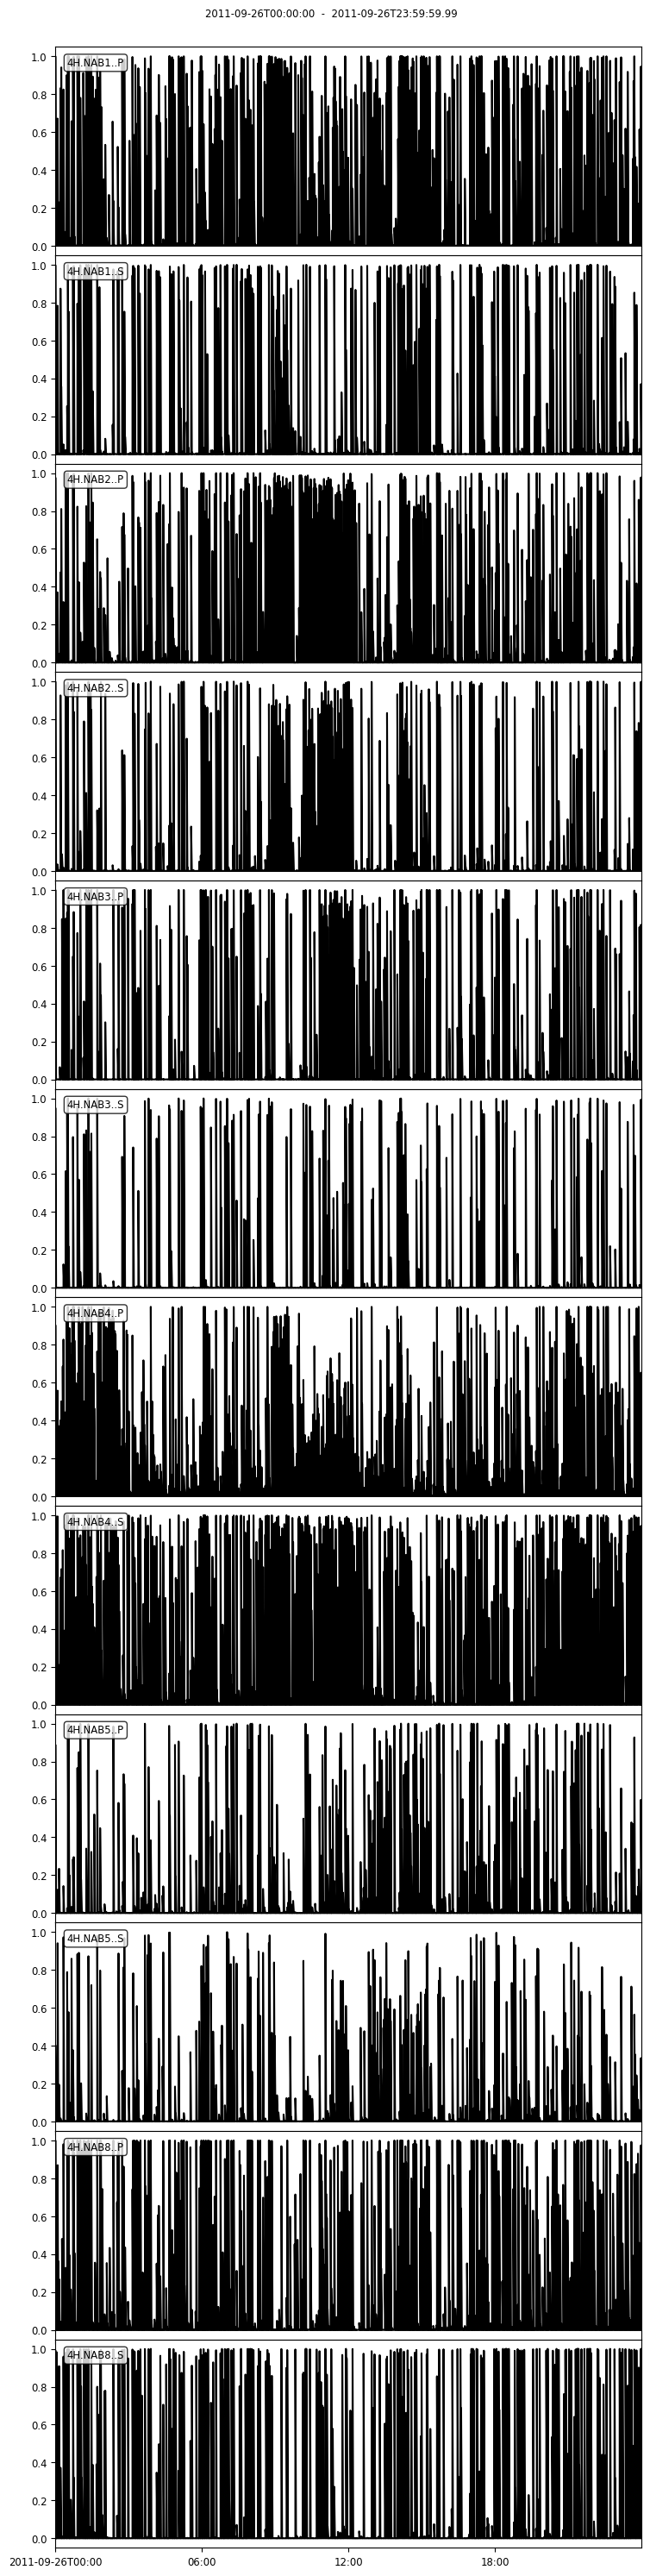

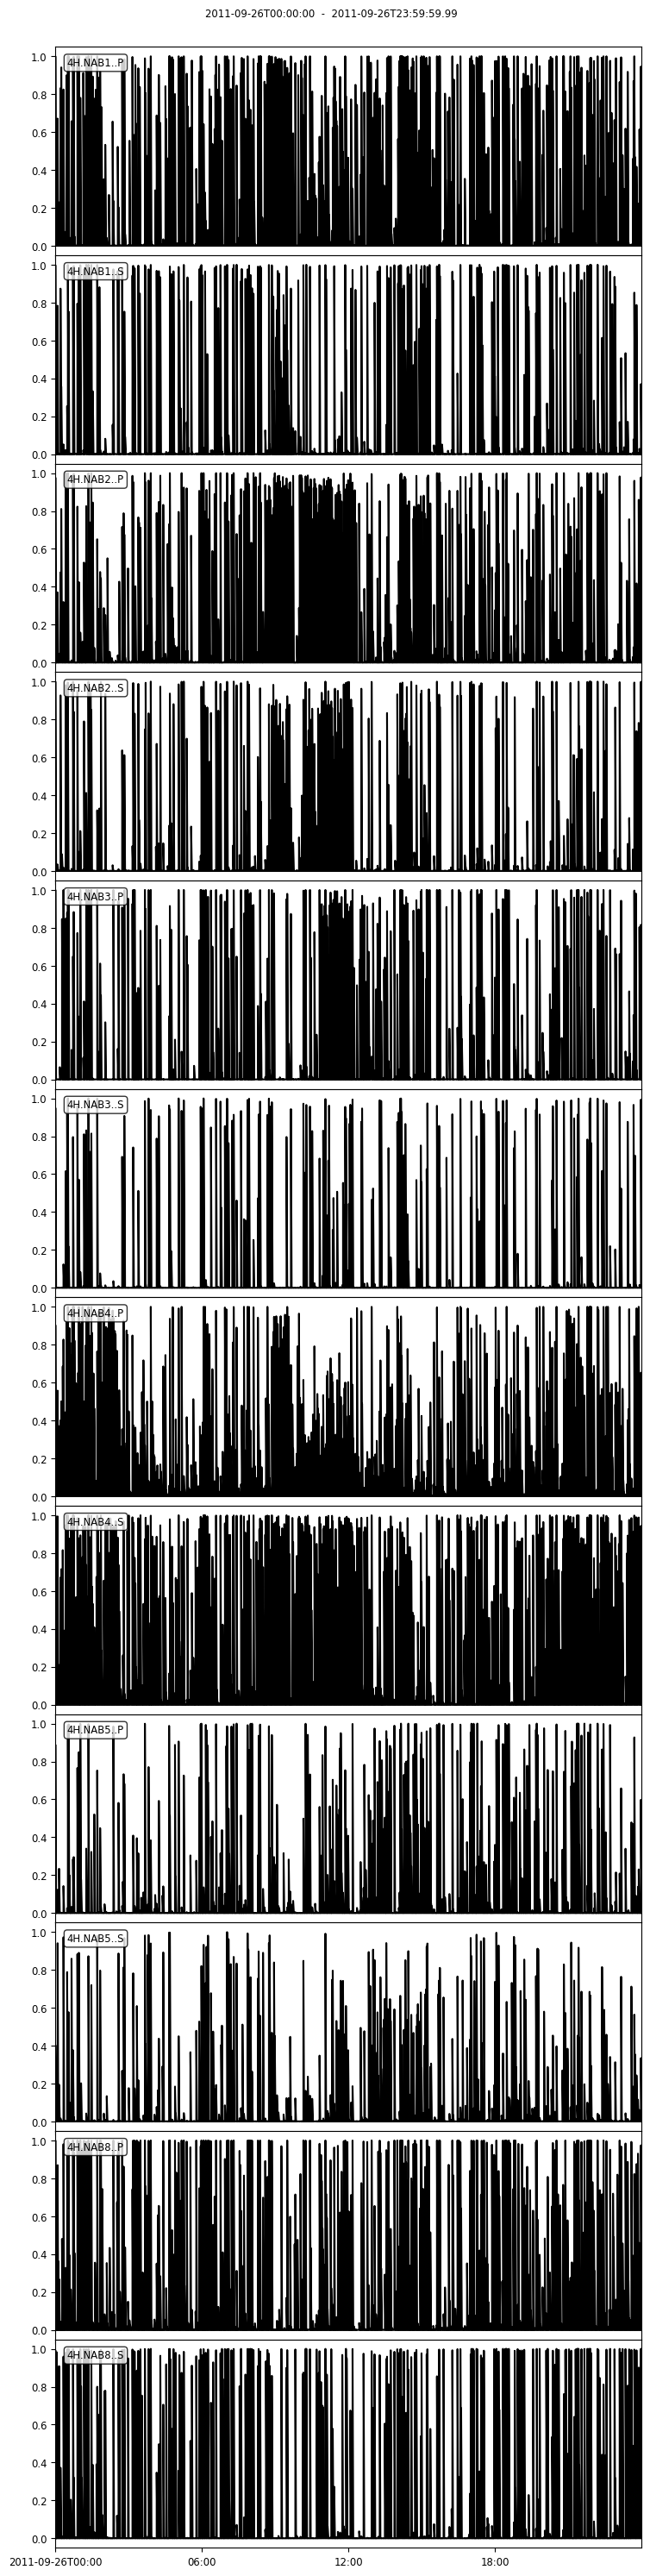

In [15]:
# Plot of machine learning prediction traces for each station
st_pred.plot()

## 7. Associate predicted phase arrivals for event location

In our paper, we locate events using model picks using the following approach:
- First group P-wave arrivals into 4-second 'bins'. This should encompass the largest arrival time difference between all our stations (i.e., 4 seconds is larger than the maximum theoretical travel time between any two stations).
- We then locate events using just these P-wave groupings and use the origin times to determine which S-wave picks should be associated to each P-wave grouping. A Vp/Vs ratio of 1.76 and travel time error of 50% is used to do this.
- Finally, events are located again using associated P- and S-wave picks.

Before associating picks, let's look at our dataframe of model pick times:

In [16]:
# Machine learning picks (when above predictions exceed threshold of 0.4)
df

,time,sta,pha,prob
0,2011-09-26T00:01:37.030000Z,NAB1,p,1.000000
1,2011-09-26T00:01:37.500000Z,NAB3,p,1.000000
2,2011-09-26T00:01:37.620000Z,NAB2,p,0.976158
3,2011-09-26T00:01:37.910000Z,NAB1,s,0.997543
4,2011-09-26T00:01:37.940000Z,NAB5,p,0.888443
...,...,...,...,...
4600,2011-09-26T23:57:27.520000Z,NAB2,s,0.998365
4601,2011-09-26T23:57:27.870000Z,NAB8,s,0.999995
4602,2011-09-26T23:57:27.890000Z,NAB5,p,0.597952
4603,2011-09-26T23:57:28.250000Z,NAB1,p,0.945742


In [17]:
# By station
for s in list(set(df['sta'])):
    no_p_picks = df.loc[(df['sta'] == s) & (df['pha'] == "p")].shape[0]
    no_s_picks = df.loc[(df['sta'] == s) & (df['pha'] == "s")].shape[0]
    print("Station " + s + ": " + str(no_p_picks) + " P-waves and " + str(no_s_picks) + " S-waves.")

Station NAB3: 289 P-waves and 165 S-waves.
Station NAB5: 212 P-waves and 170 S-waves.
Station NAB8: 370 P-waves and 292 S-waves.
Station NAB4: 498 P-waves and 824 S-waves.
Station NAB1: 617 P-waves and 269 S-waves.
Station NAB2: 584 P-waves and 315 S-waves.


We have a few thousand picks and potentially hundreds of events in this day (this is an active volcano after all!).

We can see at the start and end of this dataframe (`df`) that we have P- and S-wave picks across several stations that occur very close together in time. This is a good sign that we are detecting true phase arrivals and that we will be able to locate their events.

Let's group P-wave arrivals into 4 second bins and see how many locatable events we have.

In [18]:
df_p = df.loc[df['pha'] == "p"] # Extract just P-wave picks
df_p.reset_index(drop=True, inplace=True) # Reset dataframe indexing

pick_groups = [] # Create empty list to store P-wave groupings

# First loop through each pick finding all picks within 4 seconds of that pick - this takes around 20 secs
for i in range(df_p.shape[0]):
    this_time = df_p['time'][i]
    this_bin = df_p.loc[(df_p['time'] >= this_time) & (df_p['time'] <= (this_time + 4))]
    
    # If 4+ stations then add to pick_groups list
    if this_bin.shape[0] >= 4:
        if len(list(set(this_bin['sta']))) >= 4:
            pick_groups.append(this_bin)

# Remove groups that are fully contained in another
# First 'backwards' (remove groups that are fully contained in the previous group)
for i in reversed(range(len(pick_groups))):
    if i == 0:
        continue
    else:
        if pick_groups[i].isin(pick_groups[(i-1)]).all().all():
            del(pick_groups[i])
# Then 'forwards' (remove groups that are fully contained in the next group)
for i in reversed(range(len(pick_groups)-1)):
    if pick_groups[i].isin(pick_groups[(i+1)]).all().all():
        del(pick_groups[i])

print("Total no. of P-wave groups = " + str(len(pick_groups)))


Total no. of P-wave groups = 171


Let's look at our groupings so far...

In [19]:
pick_groups

[                          time   sta pha      prob
 0  2011-09-26T00:01:37.030000Z  NAB1   p  1.000000
 1  2011-09-26T00:01:37.500000Z  NAB3   p  1.000000
 2  2011-09-26T00:01:37.620000Z  NAB2   p  0.976158
 3  2011-09-26T00:01:37.940000Z  NAB5   p  0.888443
 4  2011-09-26T00:01:38.460000Z  NAB4   p  0.903033
 5  2011-09-26T00:01:38.510000Z  NAB8   p  0.999999,
                            time   sta pha      prob
 39  2011-09-26T00:28:46.830000Z  NAB1   p  0.555518
 40  2011-09-26T00:28:46.990000Z  NAB4   p  0.922807
 41  2011-09-26T00:28:47.420000Z  NAB1   p  0.899150
 42  2011-09-26T00:28:47.440000Z  NAB2   p  0.894574
 43  2011-09-26T00:28:50.480000Z  NAB3   p  0.472990,
                            time   sta pha      prob
 44  2011-09-26T00:29:46.140000Z  NAB4   p  0.882779
 45  2011-09-26T00:29:47.940000Z  NAB1   p  0.894546
 46  2011-09-26T00:29:48.050000Z  NAB3   p  0.881617
 47  2011-09-26T00:29:48.340000Z  NAB2   p  0.638600
 48  2011-09-26T00:29:48.480000Z  NAB8   p  0.92703

These groupings look pretty good already, although some have more than one P-wave pick per station and some overlap with other groups, usually where one group incorporates an earlier pick and the next group incorporates a later pick (outside of the 4 second window). We'll see below that this is a relatively small proportion of groups.

To deal with having more than one pick per station, let's increase the probability threshold in those groups (so we can have higher confidence in these picks) and then keep the picks with highest probability for each station.

After that, let's remove any overlapping groups by keeping the group with highest mean pick probability. Another option could be to merge overlapping groups, but that is a matter of choice. We are broadly trying to evaluate our model's suitability for detecting events in continuous data rather than assess our phase association method.

In [20]:
# Check for any groups that have more than 1 pick - first increase threshold for all picks then use phase w/ highest prob
for i in reversed(range(len(pick_groups))):
    if pick_groups[i]['sta'].duplicated().any(): # If more than one pick for any station
        pick_groups[i] = pick_groups[i].loc[pick_groups[i]['prob'] >= 0.6] # First only keep picks above higher threshold (0.6)

        if len(list(set(pick_groups[i]['sta']))) < 4:
            del(pick_groups[i]) # Remove group if increased threshold reduces number of stations to less than 4
        else:
            # Otherwise check if any stations still have more than one pick and keep only highest probability pick
            if pick_groups[i]['sta'].duplicated().any():
                pick_groups[i] = pick_groups[i].sort_values('prob').drop_duplicates('sta', keep='last')

print("No. of P-wave groups after increasing threshold for groups with multiple picks per station and reducing no. of picks to one per station = " + str(len(pick_groups)))

# Then check for overlapping groups and choose group with highest mean probability
for i in reversed(range(len(pick_groups)-1)):
    if pick_groups[i].index.isin(pick_groups[i+1].index).any():
        if np.mean(pick_groups[i]['prob']) >= np.mean(pick_groups[i+1]['prob']):
            del(pick_groups[i+1])
        else:
            del(pick_groups[i])

print("No. of P-wave groups after removing overlapping groups = " + str(len(pick_groups)))

No. of P-wave groups after increasing threshold for groups with multiple picks per station and reducing no. of picks to one per station = 156
No. of P-wave groups after removing overlapping groups = 146


The above grouping algorithm leaves us with 146 locatable events.

The next step is to put them in a format for locating events in [NonLinLoc](http://alomax.free.fr/nlloc/), a popular software package for probabilistic earthquake location.

In [21]:
# Make directories to store NLL pickfile, velocity model, travel time grid and locations
!mkdir ./NLL
!mkdir ./NLL/picks
!mkdir ./NLL/model
!mkdir ./NLL/time
!mkdir ./NLL/loc

In [22]:
# Loop through groups of picks, producing strings to go in NonLinLoc phase input file (e.g., http://alomax.free.fr/nlloc/soft7.00/formats.html#_phase_nlloc_)
# And then write strings to NLL phase input file

phase_file_str = [] # List to store strings for NLL phase input file

# Loop through groups and picks producing appropriate strings for phase input file
for i in range(len(pick_groups)):
    pick_groups[i].reset_index(drop=True, inplace=True) # Reset indices for each dataframe for looping through
    for j in range(pick_groups[i].shape[0]):
        if (i > 0) and (j == 0):
            phase_file_str.append(" ") # Add a blank line after each event
        this_line = pick_groups[i]['sta'][j].ljust(7) # Station
        this_line += '?'.ljust(5) # Instrument (leave as ?)
        this_line += "?".ljust(5) # Component (leave as ?)
        this_line += "? P".ljust(9) # Onset (leave as ? as don't know if impulsive or emergent) and phase descriptor (P)
        this_line += "? " # First motion (i.e. compression/dilation, leave as ? as don't know)
        this_line += str(pick_groups[i]['time'][j].year) # Year
        this_line += str(pick_groups[i]['time'][j].month).zfill(2) # Month (2 digits)
        this_line += str(pick_groups[i]['time'][j].day).zfill(2) # Day (2 digits)
        this_line += " " + str(pick_groups[i]['time'][j].hour).zfill(2) # Hour (2 digits)
        this_line += str(pick_groups[i]['time'][j].minute).zfill(2) # Minute (2 digits)
        this_line += " " + str(pick_groups[i]['time'][j].second).zfill(2) # Second (2 digits)
        this_line += "." + str(pick_groups[i]['time'][j].microsecond).zfill(4)[:4] # Microseconds (4 digits)
        this_line += " GAU " # Error type = Gaussian
        if pick_groups[i]['prob'][j] >= 0.85:
            this_line += "5.00e-02 " # 0.05 sec err for prob >= 0.85
        elif pick_groups[i]['prob'][j] >= 0.7:
            this_line += "1.00e-01 " # 0.10 sec err for prob >= 0.7
        elif pick_groups[i]['prob'][j] >= 0.55:
            this_line += "2.00e-01 " # 0.20 sec err for prob >= 0.55
        else:
            this_line += "3.33e-01 " # 0.333 sec err for prob >= 0.4
        this_line += "-1.00e+00 " # Coda duration (negative = don't use)
        this_line += "-1.00e+00 " # Max peak-to-peak amplitude (negative = don't use)
        this_line += "-1.00e+00" # Period of amplitude reading (negative = don't use)

        phase_file_str.append(this_line) # Append line to list

# Write phase input file
with open('./NLL/picks/pickfile.hpf', 'w') as f:
    for item in phase_file_str:
        f.write("%s\n" % item)

Now we need to install NonLinLoc (seems to work but lots of warnings during `make distrib`).

In [23]:
!wget http://alomax.free.fr/nlloc/soft7.00/tar/NLL7.00_src.tgz; tar -zxf NLL7.00_src.tgz; cd src; make distrib

--2023-03-31 10:10:01--  http://alomax.free.fr/nlloc/soft7.00/tar/NLL7.00_src.tgz
Resolving alomax.free.fr (alomax.free.fr)... 212.27.63.116
Connecting to alomax.free.fr (alomax.free.fr)|212.27.63.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407847 (398K) [application/x-gzip]
Saving to: ‘NLL7.00_src.tgz’

NLL7.00_src.tgz     100%[===================>] 398.29K   228KB/s    in 1.7s    

2023-03-31 10:10:03 (228 KB/s) - ‘NLL7.00_src.tgz’ saved [407847/407847]

gcc -c -O3 -Wall -std=gnu99  NLLoc_main.c  
gcc -c -O3 -Wall -std=gnu99  NLLoc1.c  
NLLoc1.c: In function ‘NLLoc’:
NLLoc1.c:277:9: warning: ignoring return value of ‘system’, declared with attribute warn_unused_result [-Wunused-result]
  277 |         system(sys_command);
      |         ^~~~~~~~~~~~~~~~~~~
NLLoc1.c:280:9: warning: ignoring return value of ‘system’, declared with attribute warn_unused_result [-Wunused-result]
  280 |         system(sys_command);
      |         ^~~~~~~~~~~~~~~~~~~
NLL

Then we need to create velocity model and travel time grids for each station for locating events (using pre-made Control File in U-GPD GitHub repo).

In [24]:
!./src/Vel2Grid ./U-GPD/NLL/NLL_master.in
!./src/Grid2Time ./U-GPD/NLL/NLL_master.in


Recursive initialization: level 1
Rediscretized timefield dimensions: 31 31 16
Homogeneous region: x[14->15] y[15->16] z[0->2]

Starting F.D. computation...
Starting F.D. computation...
x_side 81->80: ff fb bb bf 
y_side 79->78: ff fb bb bf 
x_side 95->96: ff fb bb bf 
y_side 93->94: ff fb bb bf 
z_side 7->8: ff fb bb bf 
x_side 80->79: ff fb bb bf 
y_side 78->77: ff fb bb bf 
x_side 96->97: ff fb bb bf 
y_side 94->95: ff fb bb bf 
z_side 8->9: ff fb bb bf 
x_side 79->78: ff fb bb bf 
y_side 77->76: ff fb bb bf 
x_side 97->98: ff fb bb bf 
y_side 95->96: ff fb bb bf 
z_side 9->10: ff fb bb bf 
x_side 78->77: ff fb bb bf 
y_side 76->75: ff fb bb bf 
x_side 98->99: ff fb bb bf 
y_side 96->97: ff fb bb bf 
z_side 10->11: ff fb bb bf 
x_side 77->76: ff fb bb bf 
y_side 75->74: ff fb bb bf 
x_side 99->100: ff fb bb bf 
y_side 97->98: ff fb bb bf 
z_side 11->12: ff fb bb bf 
x_side 76->75: ff fb bb bf 
y_side 74->73: ff fb bb bf 
x_side 100->101: ff fb bb bf 
y_side 98->99: ff fb bb bf 
z_s

<br>

<br>

And then finally locate events in NonLinLoc

In [25]:
!./src/NLLoc ./U-GPD/NLL/NLL_master.in

Finished event location, output files: ./NLL/loc/ALL.20110926.000137.* <./NLL/loc/ALL.20110926.000137.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20110926.002946.* <./NLL/loc/ALL.20110926.002946.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20110926.003202.* <./NLL/loc/ALL.20110926.003202.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20110926.003231.* <./NLL/loc/ALL.20110926.003231.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20110926.004338.* <./NLL/loc/ALL.20110926.004338.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20110926.004549.* <./NLL/loc/ALL.20110926.004549.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20110926.005500.* <./NLL/loc/ALL.20110926.005500.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20110926.005737.* <./NLL/loc/ALL.20110926.005737.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20110926.01

Now we have event locations from our P-wave groupings, we can use these to determine which S-wave picks should be included for each event.

The code cell below extracts event origin time info from NonLinLoc output files, calculates the difference between our P-wave arrival times and event origin times, and then looks through our model's S-wave picks to see if any should be associated to our events (using a Vp/Vs ratio of 1.76 and 50% travel time error).

In [26]:
# Read in origin times from NLL location summary file:
with open("./NLL/loc/ALL.sum.grid0.loc.hyp","r") as fi:
    origins = []
    for ln in fi:
        if ln.startswith("GEOGRAPHIC"):
            origins.append(ln[15:42]) # Take origin time info from GEOGRAPHIC line in summary hyp file

# Loop through and convert origin times to UTCDateTime
for i in range(len(origins)):
    origins[i] = UTCDateTime(origins[i][:4] + origins[i][5:7] + origins[i][8:10] + "T" + origins[i][12:14] + origins[i][15:17] + ("%.4f" % float(origins[i][18:27])).zfill(7))

# Get dataframe of model S-wave picks
df_s = df.loc[df['pha'] == "s"] # Extract just S-wave picks
df_s.reset_index(drop=True, inplace=True) # Reset dataframe indexing

# Then loop through P-wave pick groups finding any S-waves to add:
for i in range(len(pick_groups)):
    # Add columns for new S-wave times and probabilities:
    pick_groups[i]['s_time'] = pick_groups[i]['time'] # Just put S-wave time = P-wave time initially
    pick_groups[i]['s_prob'] = 0. # Put zero probability initially
    # Loop through picks in each group
    for j in range(pick_groups[i].shape[0]):
        p_origin_diff = pick_groups[i]['time'][j] - origins[i] # P arrival time minus origin time
        s_window = df_s.loc[(df_s['time'] >= origins[i] + (p_origin_diff * 1.76 * 0.67)) & (df_s['time'] <= origins[i] + (p_origin_diff * 1.76 * 1.5))] # Any picks within predicted S arrival window?
        s_window = s_window.loc[s_window['sta'] == pick_groups[i]['sta'][j]] # Any S picks within window and from this station?
        # If so...
        if s_window.shape[0] > 0:
            if s_window.shape[0] > 1:
                # If more than one pick for this station, use pick with highest probability
                s_window = s_window.sort_values('prob').drop_duplicates('sta', keep='last')
            s_window.reset_index(inplace=True, drop=True) # Reset index
            # Add pick to pick_groups dataframe
            pick_groups[i]['s_time'][j] = s_window['time'][0]
            pick_groups[i]['s_prob'][j] = s_window['prob'][0]

<ipython-input-26-bacb1e834918>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'] = pick_groups[i]['time'] # Just put S-wave time = P-wave time initially
<ipython-input-26-bacb1e834918>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'] = 0. # Put zero probability initially
<ipython-input-26-bacb1e834918>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [27]:
# A quick look at our new groupings
pick_groups

[                          time   sta pha      prob  \
 0  2011-09-26T00:01:37.030000Z  NAB1   p  1.000000   
 1  2011-09-26T00:01:37.500000Z  NAB3   p  1.000000   
 2  2011-09-26T00:01:37.620000Z  NAB2   p  0.976158   
 3  2011-09-26T00:01:37.940000Z  NAB5   p  0.888443   
 4  2011-09-26T00:01:38.460000Z  NAB4   p  0.903033   
 5  2011-09-26T00:01:38.510000Z  NAB8   p  0.999999   
 
                         s_time    s_prob  
 0  2011-09-26T00:01:37.910000Z  0.997543  
 1  2011-09-26T00:01:38.890000Z  0.949006  
 2  2011-09-26T00:01:38.560000Z  0.999607  
 3  2011-09-26T00:01:39.010000Z  0.401802  
 4  2011-09-26T00:01:39.820000Z  0.998658  
 5  2011-09-26T00:01:40.170000Z  0.992487  ,
                           time   sta pha      prob  \
 0  2011-09-26T00:29:46.140000Z  NAB4   p  0.882779   
 1  2011-09-26T00:29:47.940000Z  NAB1   p  0.894546   
 2  2011-09-26T00:29:48.050000Z  NAB3   p  0.881617   
 3  2011-09-26T00:29:48.340000Z  NAB2   p  0.638600   
 4  2011-09-26T00:29:48.48000

Then finally re-write our NonLinLoc phase input file and run it again to locate events with P's and S's.

In [28]:
# Rewrite NLL phase input file:

phase_file_str = [] # Empty list to store strings for NLL phase input file

# Loop through groups and picks producing appropriate strings for phase input file
for i in range(len(pick_groups)):
    pick_groups[i].reset_index(drop=True, inplace=True) # Reset indices for each dataframe for looping through
    for j in range(pick_groups[i].shape[0]):
        if (i > 0) and (j == 0):
            phase_file_str.append(" ") # Add a blank line after each event
        this_line = pick_groups[i]['sta'][j].ljust(7) # Station
        this_line += '?'.ljust(5) # Instrument (leave as ?)
        this_line += "?".ljust(5) # Component (leave as ?)
        this_line += "? P".ljust(9) # Onset (leave as ? as don't know if impulsive or emergent) and phase descriptor (P)
        this_line += "? " # First motion (i.e. compression/dilation, leave as ? as don't know)
        this_line += str(pick_groups[i]['time'][j].year) # Year
        this_line += str(pick_groups[i]['time'][j].month).zfill(2) # Month (2 digits)
        this_line += str(pick_groups[i]['time'][j].day).zfill(2) # Day (2 digits)
        this_line += " " + str(pick_groups[i]['time'][j].hour).zfill(2) # Hour (2 digits)
        this_line += str(pick_groups[i]['time'][j].minute).zfill(2) # Minute (2 digits)
        this_line += " " + str(pick_groups[i]['time'][j].second).zfill(2) # Second (2 digits)
        this_line += "." + str(pick_groups[i]['time'][j].microsecond).zfill(4)[:4] # Microseconds (4 digits)
        this_line += " GAU " # Error type = Gaussian
        if pick_groups[i]['prob'][j] >= 0.85:
            this_line += "5.00e-02 " # 0.05 sec err for prob >= 0.85
        elif pick_groups[i]['prob'][j] >= 0.7:
            this_line += "1.00e-01 " # 0.10 sec err for prob >= 0.7
        elif pick_groups[i]['prob'][j] >= 0.55:
            this_line += "2.00e-01 " # 0.20 sec err for prob >= 0.55
        else:
            this_line += "3.33e-01 " # 0.333 sec err for prob >= 0.4
        this_line += "-1.00e+00 " # Coda duration (negative = don't use)
        this_line += "-1.00e+00 " # Max peak-to-peak amplitude (negative = don't use)
        this_line += "-1.00e+00" # Period of amplitude reading (negative = don't use)

        phase_file_str.append(this_line) # Append line to list

        # Check if there is an associated S-wave pick for this station and append to the phase file:
        if pick_groups[i]['s_prob'][j] >= 0.4:
            this_line = pick_groups[i]['sta'][j].ljust(7) # Station
            this_line += '?'.ljust(5) # Instrument (leave as ?)
            this_line += "?".ljust(5) # Component (leave as ?)
            this_line += "? S".ljust(9) # Onset (leave as ? as now S-wave) and phase descriptor (S)
            this_line += "? " # First motion (i.e. compression/dilation, leave as ? as now S-wave)
            this_line += str(pick_groups[i]['s_time'][j].year) # Year
            this_line += str(pick_groups[i]['s_time'][j].month).zfill(2) # Month (2 digits)
            this_line += str(pick_groups[i]['s_time'][j].day).zfill(2) # Day (2 digits)
            this_line += " " + str(pick_groups[i]['s_time'][j].hour).zfill(2) # Hour (2 digits)
            this_line += str(pick_groups[i]['s_time'][j].minute).zfill(2) # Minute (2 digits)
            this_line += " " + str(pick_groups[i]['s_time'][j].second).zfill(2) # Second (2 digits)
            this_line += "." + str(pick_groups[i]['s_time'][j].microsecond).zfill(4)[:4] # Microseconds (4 digits)
            this_line += " GAU " # Error type = Gaussian
            # Keep same error magnitudes as P-wave arrivals
            if pick_groups[i]['prob'][j] >= 0.85:
                this_line += "5.00e-02 " # 0.05 sec err for prob >= 0.85
            elif pick_groups[i]['prob'][j] >= 0.7:
                this_line += "1.00e-01 " # 0.10 sec err for prob >= 0.7
            elif pick_groups[i]['prob'][j] >= 0.55:
                this_line += "2.00e-01 " # 0.20 sec err for prob >= 0.55
            else:
                this_line += "3.33e-01 " # 0.333 sec err for prob >= 0.4
            this_line += "-1.00e+00 " # Coda duration (negative = don't use)
            this_line += "-1.00e+00 " # Max peak-to-peak amplitude (negative = don't use)
            this_line += "-1.00e+00" # Period of amplitude reading (negative = don't use)

            phase_file_str.append(this_line) # Append line to list

# Write new phase file
with open('./NLL/picks/pickfile_s.hpf', 'w') as f:
    for item in phase_file_str:
        f.write("%s\n" % item)

In [29]:
# Make new directory for locating events with S-waves included:
!mkdir ./NLL/loc_s

In [30]:
#### UNCOMMENT THESE LINES IF USING DEFINED S-WAVE VELOCITY (i.e., not using constant Vp/Vs ratio) ####

# Create velocity and travel-time grids for S-wave velocity model
#!./src/Vel2Grid ./U-GPD/NLL/NLL_master_s.in
#!./src/Grid2Time ./U-GPD/NLL/NLL_master_s.in

# Run NonLinLoc again (using pre-made Control File for including S-waves)
#!./src/NLLoc ./U-GPD/NLL/NLL_master_s.in

In [31]:
#### LEAVE THESE LINES UNCOMMENTED IF USING CONSTANT Vp/Vs ####
# Run NonLinLoc again (using pre-made Control File for including S-waves)
!./src/NLLoc ./U-GPD/NLL/NLL_master_s_constantVpVs.in

Finished event location, output files: ./NLL/loc_s/ALL.20110926.000137.* <./NLL/loc_s/ALL.20110926.000137.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc_s/ALL.20110926.002946.* <./NLL/loc_s/ALL.20110926.002946.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc_s/ALL.20110926.003202.* <./NLL/loc_s/ALL.20110926.003202.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc_s/ALL.20110926.003231.* <./NLL/loc_s/ALL.20110926.003231.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc_s/ALL.20110926.004338.* <./NLL/loc_s/ALL.20110926.004338.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc_s/ALL.20110926.004549.* <./NLL/loc_s/ALL.20110926.004549.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc_s/ALL.20110926.005500.* <./NLL/loc_s/ALL.20110926.005500.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc_s/ALL.20110926.005737.* <./NLL/loc_s/ALL.20110926.005737.grid0.loc.hyp>
Finished event location, output 

## 8. Final event locations

The very last step is to read in our final event locations for plotting or further analysis. You can obviously extract other information from the NonLinLoc output files in `./NLL/loc_s`, such as horizontal and vertical Gaussian errors (as presented in our paper) or importance sampling outputs (e.g., pdf scatter and likelihood values for each event).

Phase information from our model picks can be accessed from the NonLinLoc phase input file we produced earlier (`./NLL/picks/pickfile_s.hpf`) and used to isolate phase arrivals for calulating moment magnitudes, etc.

The plots in our original paper were all produced in R so for now we'll just read the event locations into a pandas dataframe and leave you to experiment further.

In [32]:
origins = []
lats = []
lons = []
depths = []

with open("./NLL/loc_s/ALL.sum.grid0.loc.hyp","r") as fi:
    for ln in fi:
        if ln.startswith("GEOGRAPHIC"):
            origins.append(ln[15:42])
            lats.append(float(ln.split("Lat", 1)[1].split("Long", 1)[0]))
            lons.append(float(ln.split("Lat", 1)[1].split("Long", 1)[1].split("Depth")[0]))
            depths.append(float(ln.split("Lat", 1)[1].split("Long", 1)[1].split("Depth")[-1]))

# # Loop through and convert origin times to UTCDateTime
for i in range(len(origins)):
    origins[i] = UTCDateTime(origins[i][:4] + origins[i][5:7] + origins[i][8:10] + "T" + origins[i][12:14] + origins[i][15:17] + ("%.4f" % float(origins[i][18:27])).zfill(7))

# Create dataframe of event locations
df_events = pd.DataFrame(list(zip(origins, lats, lons, depths)), 
               columns =['time', 'lat', 'lon', 'depth'])

In [33]:
# Quick look at events dataframe
df_events

,time,lat,lon,depth
0,2011-09-26T00:01:36.195000Z,13.381161,41.689154,2.497159
1,2011-09-26T00:29:46.314400Z,13.348214,41.706988,-0.784091
2,2011-09-26T00:32:01.212800Z,13.378080,41.685432,3.421875
3,2011-09-26T00:32:29.886900Z,13.280982,41.669157,3.332386
4,2011-09-26T00:43:37.325200Z,13.408750,41.712060,10.551136
...,...,...,...,...
141,2011-09-26T22:32:19.207500Z,13.435804,41.647945,5.122159
142,2011-09-26T22:40:59.889000Z,13.289821,41.669998,2.437500
143,2011-09-26T23:04:41.829000Z,13.400179,41.789142,8.403409
144,2011-09-26T23:41:30.267400Z,13.375937,41.686254,2.348011


In [34]:
# For each event, cut traces and save pick times in SAC files

import re

save_path = "./2011-269"
os.system('mkdir ' + save_path)

t_before_origin = 10 # Start SAC traces 10 sec before origin time
t_after_origin = 80 # End SAC traces 80 sec after origin time

for event_no in range(len(df_events)):
    event_origin = df_events.time.values[event_no]
    st_event = st.copy().trim(starttime=event_origin - t_before_origin, 
                              endtime=event_origin + t_after_origin)
    
    # Go through each trace...
    for tr in st_event:
        # Get pick times for this trace
        this_station_pick = pick_groups[event_no][pick_groups[event_no]['sta'] == tr.stats.station]
        this_station_pick.reset_index(inplace=True, drop=True)

        # Save trace as SAC file
        tr_filename = ''.join(re.split('[-:.]', str(event_origin))) + "." + tr.stats.station + "." + tr.stats.channel + ".SAC"
        tr.write(save_path + "/" + tr_filename, format="SAC") 

        # If no pick time, go on to next trace
        if len(this_station_pick) < 1:
            continue

        # Read SAC file back in (for SAC header)
        tr = oc.read(save_path + "/" + tr_filename)[0]

        # Set variables in SAC header (see http://www.adc1.iris.edu/files/sac-manual/manual/file_format.html for more details)
        tr.stats.sac.o = t_before_origin # Set origin time in trace
        tr.stats.sac.a = this_station_pick.time[0] - event_origin + t_before_origin # Set P-pick time
        if this_station_pick.s_prob[0] > 0:
            tr.stats.sac.t0 = this_station_pick.s_time[0] - event_origin + t_before_origin # Set S-pick time

        # Save SAC file again
        tr.write(save_path + "/" + tr_filename, format="SAC")     